# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data_text/cleaned_reviews.csv', encoding="ISO-8859-1")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()
len(df)

17340

In [3]:
df.isnull().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
len(df)

17337

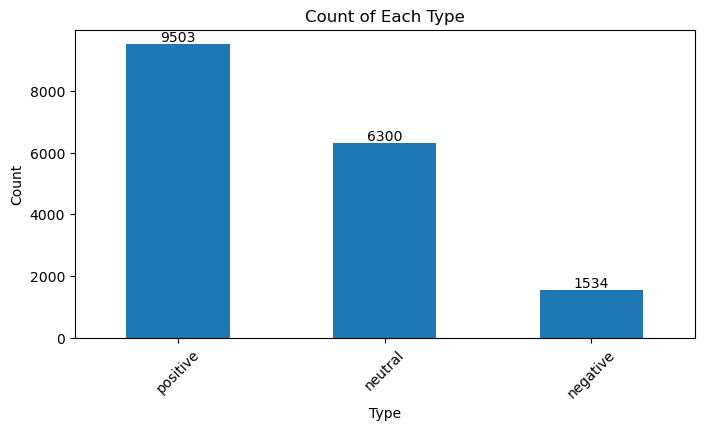

In [7]:
type_counts = df.sentiments.value_counts(dropna=False)
plt.figure(figsize=(8, 4))
bars = type_counts.plot(kind='bar')
plt.title('Count of Each Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

for index, value in enumerate(type_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

# Preprocessing

In [8]:
from nltk.stem import PorterStemmer
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [9]:
ps = PorterStemmer() 

def preprocessing(sentence, lemma=True, stemming=True, tokenize=True, stopword=True):

    sentence = str(sentence).lower()
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', ' ', sentence)
    sentence = re.sub(' +', ' ', sentence)

    if tokenize:
        words = word_tokenize(sentence)
    else:
        words = sentence.split()

    if stopword:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

    if stemming:
        words = [ps.stem(word) for word in words]

    if lemma:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words), words

In [10]:
df['processed_text'] = ""
df['words_list'] = None

In [11]:
for i, row in df.iterrows():
    processed_sentence, words_list = preprocessing(row['cleaned_review'])
    df.at[i, 'processed_text'] = processed_sentence
    df.at[i, 'words_list'] = words_list

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df.sentiments, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Word2vec

In [14]:
import itertools
from collections import Counter
from gensim.models import word2vec
import os

In [15]:
def build_vocab(sentences):
    word_counts = Counter(itertools.chain(*sentences))
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

In [16]:
#Get word embeddings with 100 dimensions

def get_embeddings(inp_data, vocabulary_inv, size_features=100,
                   mode='skipgram', min_word_count=2, context= 7, negative_samples=0, hs = 1):
    model_name = "embedding"
    model_name = os.path.join(model_name)
    num_workers = 15 
    downsampling = 1e-2  
    print('Training Word2Vec model...')
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
    sg = 1 if mode == 'skipgram' else 0
    print(f'Model: {mode}')

    embedding_model = word2vec.Word2Vec(sentences, 
                                        workers=num_workers,
                                        sg=sg, 
                                        vector_size=size_features,
                                        min_count=min_word_count, 
                                        window=context,
                                        seed = 42, 
                                        sample=downsampling, 
                                        hs = hs,
                                        negative=negative_samples)
    
    print("Saving Word2Vec model {}".format(model_name))
    
    embedding_weights = np.zeros((len(vocabulary_inv), size_features))
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model.wv:
            embedding_weights[i] = embedding_model.wv[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25, embedding_model.vector_size)

    return embedding_weights

In [18]:
tagged_train_data = [word_tokenize(review) for review in X_train]
tagged_test_data = [word_tokenize(review) for review in X_test]
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_train_data)
inp_data = [[vocabulary[word] for word in text] for text in tagged_train_data]

In [19]:
embedding_weights_2vec = get_embeddings(inp_data, vocabulary_inv)

Training Word2Vec model...
Model: skipgram
Saving Word2Vec model embedding


In [20]:
train_vec = []
for doc in tagged_train_data:
    vec = 0
    length = 1
    for w in doc:
        try:
            vec += embedding_weights_2vec[vocabulary[w]]
            length += 1
        except:
            continue
    vec = vec / length
    train_vec.append(vec)

test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 1
    for w in doc:
        try:
            vec += embedding_weights_2vec[vocabulary[w]]
            length += 1
        except:
            continue
    vec = vec / length
    test_vec.append(vec)

In [26]:
lengths = []
for i, elem in enumerate(train_vec):
    try:
        lengths.append(len(elem))
    except TypeError:
        print(f"Element at index {i} is not a sequence.")

if len(set(lengths)) == 1:
    print("All elements have the same length.")
else:
    print("Elements have varying lengths.")

print(f"All lengths: {set(lengths)}")


Element at index 889 is not a sequence.
Element at index 976 is not a sequence.
Element at index 1419 is not a sequence.
Element at index 2692 is not a sequence.
Element at index 2704 is not a sequence.
Element at index 2762 is not a sequence.
Element at index 3444 is not a sequence.
Element at index 3619 is not a sequence.
All elements have the same length.
All lengths: {100}


In [28]:
# Identify indices of elements that are not sequences or have incorrect length
invalid_indices = [i for i, elem in enumerate(train_vec) if not isinstance(elem, (list, np.ndarray)) or len(elem) != 100]

# Remove invalid elements from train_vec and corresponding labels from y_train
cleaned_train_vec = [elem for i, elem in enumerate(train_vec) if i not in invalid_indices]
cleaned_y_train = [label for i, label in enumerate(y_train) if i not in invalid_indices]

# Check the results
print(f"Original length: {len(train_vec)}, Cleaned length: {len(cleaned_train_vec)}")
print(f"Original labels length: {len(y_train)}, Cleaned labels length: {len(cleaned_y_train)}")


Original length: 6934, Cleaned length: 6926
Original labels length: 6934, Cleaned labels length: 6926


In [30]:
invalid_indices = [i for i, elem in enumerate(test_vec) if not isinstance(elem, (list, np.ndarray)) or len(elem) != 100]

cleaned_test_vec = [elem for i, elem in enumerate(test_vec) if i not in invalid_indices]
cleaned_y_test = [label for i, label in enumerate(y_test) if i not in invalid_indices]

print(f"Original length: {len(test_vec)}, Cleaned length: {len(cleaned_test_vec)}")
print(f"Original labels length: {len(y_test)}, Cleaned labels length: {len(cleaned_y_test)}")

Original length: 3468, Cleaned length: 3455
Original labels length: 3468, Cleaned labels length: 3455


# NN

In [22]:
from sklearn.linear_model import LogisticRegression

In [32]:
clf = LogisticRegression(max_iter=100000000).fit(cleaned_train_vec, cleaned_y_train)
preds = clf.predict(cleaned_test_vec)

In [37]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
accuracy = accuracy_score(cleaned_y_test, preds)
print(f"Accuracy: {accuracy}")

f1_macro = f1_score(cleaned_y_test, preds, average='macro')
f1_micro = f1_score(cleaned_y_test, preds, average='micro')
print(f"Macro F1 Score: {f1_macro}")
print(f"Micro F1 Score: {f1_micro}")


Accuracy: 0.7340086830680174
Macro F1 Score: 0.537731246690587
Micro F1 Score: 0.7340086830680174
